In [1]:
#Imports with tested version
import numpy as np #'1.19.3'
import pandas as pd #'1.2.3'

import sklearn.linear_model as sklm #'0.24.1'
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt #'3.3.4'

In [2]:
#Taken from an internal utility package
class SequenceEncoder:
    """
    
    Provides different encoding schemes for amino acid sequences
    
    Arguements:
        seqs: A list of sequence strings
        ebit: Appends an error bit to the start of encoded vectors
        propdim: Places property vectors along their own axis, when applicable
    
    """
    def __init__(self, seqs, ebit=True, propdim=False):
        if not (isinstance(seqs, (list,)) or isinstance(seqs, (tuple,))):
            self.seqs = [seqs]
        else:
            self.seqs = seqs
        self.ebit = ebit
        self.propdim = propdim
        self.norm = False
        self.trim = False
        
    def _encode(self, encoder):
        if self.trim is True:
            for key in encoder:
                encoder[key] = encoder[key][1:]
        if self.norm is True:
            ma = max([encoder[x][0] for x in encoder])
            mi = min([encoder[x][0] for x in encoder])
            for key in encoder:
                encoder[key] = [(encoder[key][0] - mi)/(ma - mi)]
        self.norm = False
        self.trim = False
        encseqs = []
        for seq in self.seqs:
            if self.ebit and not self.propdim:
                encseq = [1]
            else:
                encseq = []
            for aa in seq:
                if aa not in encoder:
                    print("WARN: %s not found in chosen encoding scheme.  Ignoring..."%aa)
                    continue
                if self.propdim:
                    encseq.append(encoder[aa])
                else:
                    encseq += encoder[aa]
            encseqs.append(encseq)
        return encseqs
                
    def _setErrorBit(self, ebit=False):
        self.ebit = ebit

    def OneHotOrthoEncoder(self, trim=True, norm=False, givemap=False, silent=True):
        self.trim = trim
        self.norm = False
        resmap = []
        #Add parent (Assumed first in list) to the map first (Trim acts to map variants)
        if not silent:
            print("Parent seq: %s"%self.seqs[0])
        for aa in self.seqs[0]:
            resmap.append({aa: []})
        #Go through all sequences and find all residues
        for seq in self.seqs:
            for i in range(len(seq)):
                if seq[i] not in resmap[i]:
                    resmap[i][seq[i]] = []
        #Generate orthogonal encodings for each amino acid at each residue
        for i in range(len(resmap)):
            keys = list(resmap[i].keys())
            for j in range(len(keys)):
                resmap[i][keys[j]] = [1 if x == j else 0 for x in range(len(keys))]
                if trim:
                    resmap[i][keys[j]] = resmap[i][keys[j]][1:]
        #Encode all sequences
        encseqs = []
        for seq in self.seqs:
            if self.ebit:
                encseq = [1]
            else:
                encseq = []
            for i in range(len(seq)):
                encseq += resmap[i][seq[i]]
            encseqs.append(encseq)
        if givemap:
            return encseqs, resmap
        else:
            return encseqs

# First pass with no filtering

Total # measurements: 77
Unique sequences: 69


/home/jon/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


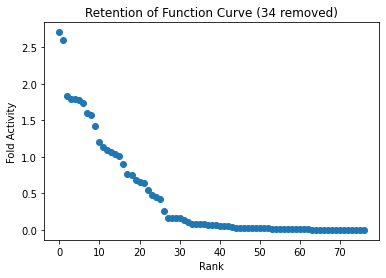

In [3]:
#Cys Shuffle fitting with filtering
INFILE = "./UstD_CysShuffDataset.csv" #Which dataset file to load
FILTER = 0.0 #Disregard measurements below this filter value

data = [[],[]]
numlost = 0
#Load data and generate RoF curve
knownacts = {}
with open(INFILE,'r') as f:
    line = f.readline()
    while len(line) > 0:
        temp = line.split(',')
        if len(temp[0]) > 0:
            if (FILTER < float(temp[1])):
                data[0].append(temp[0])
                data[1].append(float(temp[1]))
                knownacts[data[0][-1]] = data[1][-1]
            else:
                numlost += 1
        line = f.readline()

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.scatter(list(range(len(data[0]))), sorted(data[1],reverse=True))
ax.set_title("Retention of Function Curve (%s removed)"%numlost)
ax.set_xlabel("Rank")
ax.set_ylabel("Fold Activity")
fig.show()

#Get number of unique sequences
print("Total # measurements: %s"%len(data[0]))
print("Unique sequences: %s"%len(set(data[0])))

In [4]:
#Encode sequences
data[1] = np.array(data[1])
log_measurements = np.log(data[1])
encoder = SequenceEncoder(data[0])
encseqs, mapping = encoder.OneHotOrthoEncoder(givemap=True)
if len(encseqs) > len(log_measurements):
    print("WARN: Less measurements than vector size!  Watch for overfitting")

/home/jon/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


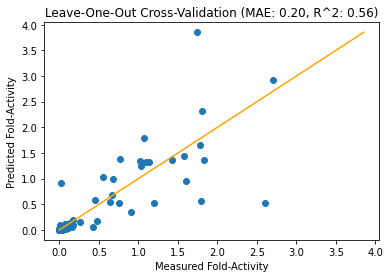

In [5]:
#Perform LOOCV to get statistics
predictions = []
for i in range(len(encseqs)):
    reg = sklm.LinearRegression(fit_intercept=False).fit(encseqs[:i] + encseqs[i+1:], np.delete(log_measurements, i))
    predictions.append(reg.predict([encseqs[i]]))
predictions = np.exp(predictions).flatten()

mae = np.average(np.abs(data[1] - predictions))#mean absolute error
rsq = r2_score(data[1], predictions)

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
x = data[1]
y = predictions
min_p = np.min([np.min(x), np.min(y)])
max_p = np.max([np.max(x), np.max(y)])

ax.plot([min_p, max_p],[min_p, max_p],color='orange')
ax.scatter(x, y)
ax.set_title("Leave-One-Out Cross-Validation (MAE: %.2f, R^2: %.2f)"%(mae, rsq))
ax.set_xlabel("Measured Fold-Activity")
ax.set_ylabel("Predicted Fold-Activity")
fig.show()

/home/jon/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


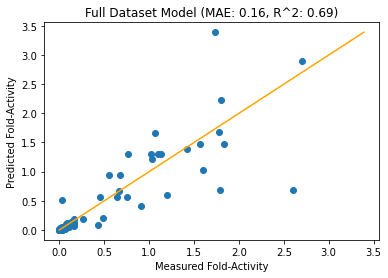

In [6]:
#Retrain on full dataset
reg = sklm.LinearRegression(fit_intercept=False).fit(encseqs, log_measurements)
predictions = reg.predict(encseqs)
predictions = np.exp(predictions)

mae = np.average(np.abs(data[1] - predictions))#mean absolute error
rsq = r2_score(data[1], predictions)

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
x = data[1]
y = predictions
min_p = np.min([np.min(x), np.min(y)])
max_p = np.max([np.max(x), np.max(y)])

ax.plot([min_p, max_p],[min_p, max_p],color='orange')
ax.scatter(x, y)
ax.set_title("Full Dataset Model (MAE: %.2f, R^2: %.2f)"%(mae, rsq))
ax.set_xlabel("Measured Fold-Activity")
ax.set_ylabel("Predicted Fold-Activity")
fig.show()

# Second pass with reduced dataset

Total # measurements: 33
Unique sequences: 26


/home/jon/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


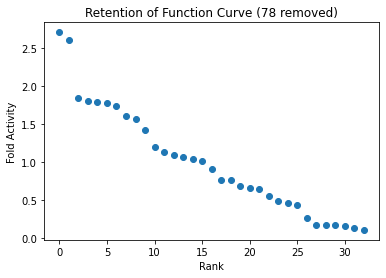

In [7]:
#Cys Shuffle fitting with filtering
INFILE = "./UstD_CysShuffDataset.csv" #Which dataset file to load
FILTER = 0.1 #Disregard measurements below this filter value

data = [[],[]]
numlost = 0
#Load data and generate RoF curve
knownacts = {}
with open(INFILE,'r') as f:
    line = f.readline()
    while len(line) > 0:
        temp = line.split(',')
        if len(temp[0]) > 0:
            if (FILTER < float(temp[1])):
                data[0].append(temp[0])
                data[1].append(float(temp[1]))
                knownacts[data[0][-1]] = data[1][-1]
            else:
                numlost += 1
        line = f.readline()

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.scatter(list(range(len(data[0]))), sorted(data[1],reverse=True))
ax.set_title("Retention of Function Curve (%s removed)"%numlost)
ax.set_xlabel("Rank")
ax.set_ylabel("Fold Activity")
fig.show()

#Get number of unique sequences
print("Total # measurements: %s"%len(data[0]))
print("Unique sequences: %s"%len(set(data[0])))

In [8]:
#Encode sequences
data[1] = np.array(data[1])
log_measurements = np.log(data[1])
encoder = SequenceEncoder(data[0])
encseqs, mapping = encoder.OneHotOrthoEncoder(givemap=True)
if len(encseqs) > len(log_measurements):
    print("WARN: Less measurements than vector size!  Watch for overfitting")

/home/jon/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


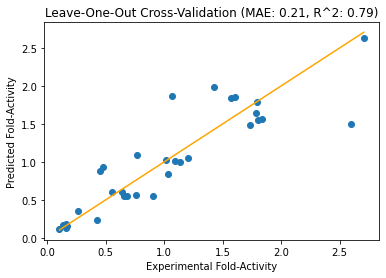

In [9]:
#Perform LOOCV to get statistics
predictions = []
for i in range(len(encseqs)):
    reg = sklm.LinearRegression(fit_intercept=False).fit(encseqs[:i] + encseqs[i+1:], np.delete(log_measurements, i))
    predictions.append(reg.predict([encseqs[i]]))
predictions = np.exp(predictions).flatten()

mae = np.average(np.abs(data[1] - predictions))#mean absolute error
rsq = r2_score(data[1], predictions)

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
x = data[1]
y = predictions
min_p = np.min([np.min(x), np.min(y)])
max_p = np.max([np.max(x), np.max(y)])

ax.plot([min_p, max_p],[min_p, max_p],color='orange')
ax.scatter(x, y)
ax.set_title("Leave-One-Out Cross-Validation (MAE: %.2f, R^2: %.2f)"%(mae, rsq))
ax.set_xlabel("Experimental Fold-Activity")
ax.set_ylabel("Predicted Fold-Activity")
fig.show()

/home/jon/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


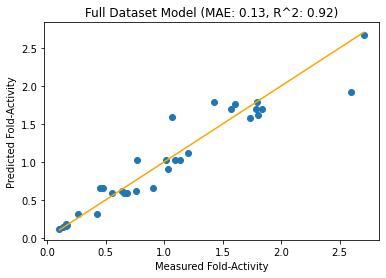

In [10]:
#Retrain on full dataset
reg = sklm.LinearRegression(fit_intercept=False).fit(encseqs, log_measurements)
predictions = reg.predict(encseqs)
predictions = np.exp(predictions)

mae = np.average(np.abs(data[1] - predictions))#mean absolute error
rsq = r2_score(data[1], predictions)

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
x = data[1]
y = predictions
min_p = np.min([np.min(x), np.min(y)])
max_p = np.max([np.max(x), np.max(y)])

ax.plot([min_p, max_p],[min_p, max_p],color='orange')
ax.scatter(x, y)
ax.set_title("Full Dataset Model (MAE: %.2f, R^2: %.2f)"%(mae, rsq))
ax.set_xlabel("Measured Fold-Activity")
ax.set_ylabel("Predicted Fold-Activity")
fig.show()

In [11]:
#Reconstruct weight matrix in a readable format
num_pos = len(mapping)
possible_aas = []
pos_list = []
counter = 1
for pos in mapping:
    temp = list(pos)[1:]
    possible_aas += temp
    pos_list += ["Pos%s"%(counter)] * len(temp)
    counter += 1
unique_aas = list(set(possible_aas))
unique_aas.sort()
unique_pos = list(set(pos_list))
unique_pos.sort()
weights = np.full((len(unique_aas), num_pos), '-', dtype=object)
weights = pd.DataFrame(weights, index=unique_aas, columns=unique_pos)
model_weights = np.exp(reg.coef_)
for i in range(len(possible_aas)):
    weights.at[possible_aas[i], pos_list[i]] = "%.1f"%model_weights[i+1]
weights.columns = ['C122X', 'C139X', 'C227X', 'C236X', 'C428X']
print("Parent Bias: %.1f"%(model_weights[0]))
display(weights)

Parent Bias: 1.0


,C122X,C139X,C227X,C236X,C428X
A,1.8,-,0.9,-,0.2
F,0.6,-,-,-,-
G,1.1,-,0.1,-,-
S,1.6,1.0,0.1,1.7,-
V,1.0,-,-,-,-
W,-,-,-,0.6,-


In [12]:
#Generate all permutations of library
permutationseqs = [[x] for x in list(mapping[0].keys())]
for i in range(1, len(mapping)):
    temp = []
    for j in permutationseqs:
        for k in mapping[i]:
            temp.append(j + [k])
    permutationseqs = temp[:]
permutationencs = {}
for seq in permutationseqs:
    enc = [1]
    for pos in range(len(seq)):
        enc += mapping[pos][seq[pos]]
    permutationencs["".join(seq)] = enc

#Create library prediction and report sorted activities
permutationpreds = reg.predict([permutationencs[x] for x in permutationencs])
permutationpreds = np.exp(permutationpreds)
permutationpreds, permutationseqs = zip(*sorted(zip(permutationpreds, permutationseqs), reverse=True))
print("TOP PREDICTED ACTIVITIES")
for i in range(10):
    key = "".join(permutationseqs[i])
    if key in knownacts:
        print("%s: %.2f(%.2f)"%(key, permutationpreds[i],knownacts[key]))
    else:
        print("%s: %.2f"%(key, permutationpreds[i]))

TOP PREDICTED ACTIVITIES
ACCSC: 3.11
ASCSC: 3.07
ACASC: 2.90
ASASC: 2.87
SCCSC: 2.86
SSCSC: 2.82
SCASC: 2.67(2.71)
SSASC: 2.63
GCCSC: 1.92(2.60)
GSCSC: 1.89
